In [5]:
# Import all required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.amp import autocast, GradScaler 
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,accuracy_score,
    roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize
import shutil
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# Create results directory
os.makedirs('results', exist_ok=True)

In [2]:
# --- Index 1: GPU Setup and Configuration ---
print("=== GPU Configuration for RTX 3060 Ti ===")

# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")
    
    # Optimize for RTX GPU
    torch.backends.cudnn.benchmark = True  # Faster convolutions
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 for matmul
    torch.backends.cudnn.allow_tf32 = True  # Allow TF32 for convolutions
    
    # Clear GPU cache
    torch.cuda.empty_cache()
else:
    print("No GPU available. Using CPU (training will be slower).")

# Set batch size based on GPU memory
batch_size = 16 if torch.cuda.is_available() else 8
print(f"Using batch size: {batch_size}")

=== GPU Configuration for RTX 3060 Ti ===
Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Ti
GPU Memory: 8.0 GB
CUDA version: 12.6
Using batch size: 16


## Data exploration

Found 6 crop types: ['corn', 'jute', 'potato', 'rice', 'sugarcane', 'wheat']
  corn_cercospora_leaf_spot: 513 images
  corn_common_rust: 1192 images
  corn_healthy: 1160 images
  corn_northern_leaf_blight: 985 images
  jute_cescospora_leaf_spot: 309 images
  jute_golden_mosaic: 347 images
  jute_healthy_leaf: 264 images
  potato_bacteria: 569 images
  potato_fungi: 748 images
  potato_healthy: 201 images
  potato_nematode: 68 images
  potato_pest: 611 images
  potato_phytopthora: 347 images
  potato_virus: 532 images
  rice_bacterial_leaf_blight: 438 images
  rice_brown_spot: 438 images
  rice_healthy: 438 images
  rice_leaf_blast: 438 images
  rice_leaf_scald: 438 images
  rice_narrow_brown_spot: 438 images
  sugarcane_healthy: 522 images
  sugarcane_mosaic: 462 images
  sugarcane_redrot: 518 images
  sugarcane_rust: 514 images
  sugarcane_yellow: 505 images
  wheat_brown_rust: 1256 images
  wheat_healthy: 1658 images
  wheat_septoria: 349 images
  wheat_smut: 939 images
  wheat_yello

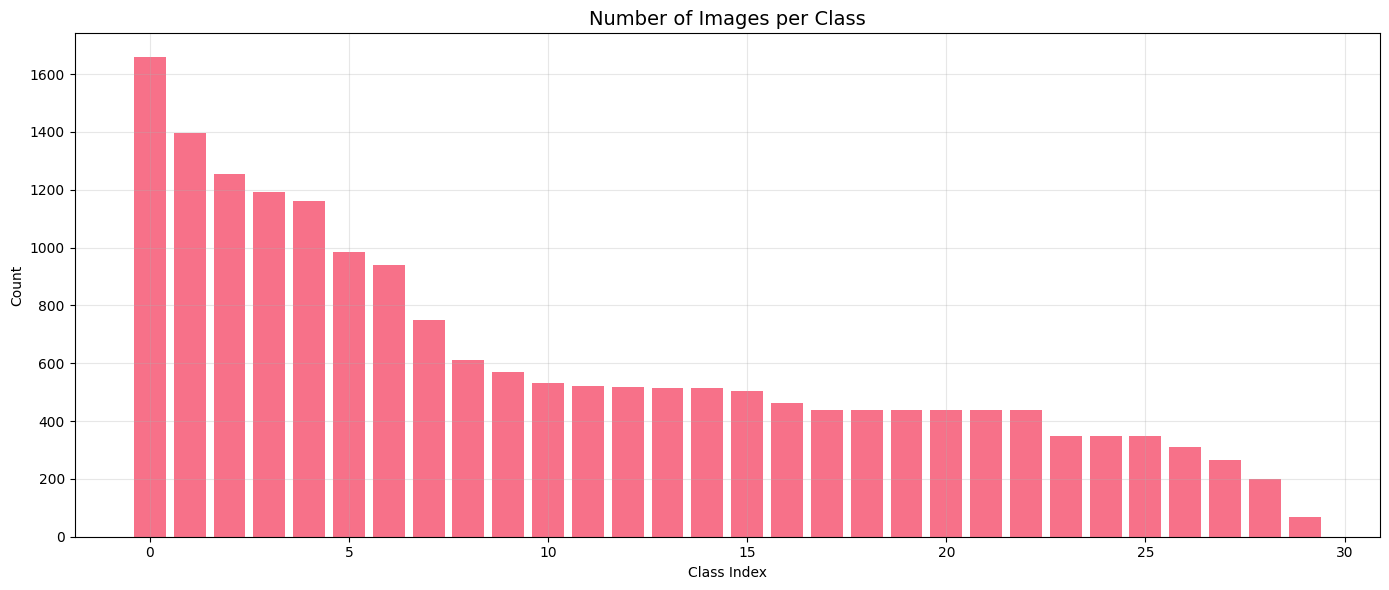


Recount total across folders (with more formats): 18592

Sample 20 images from dataset:


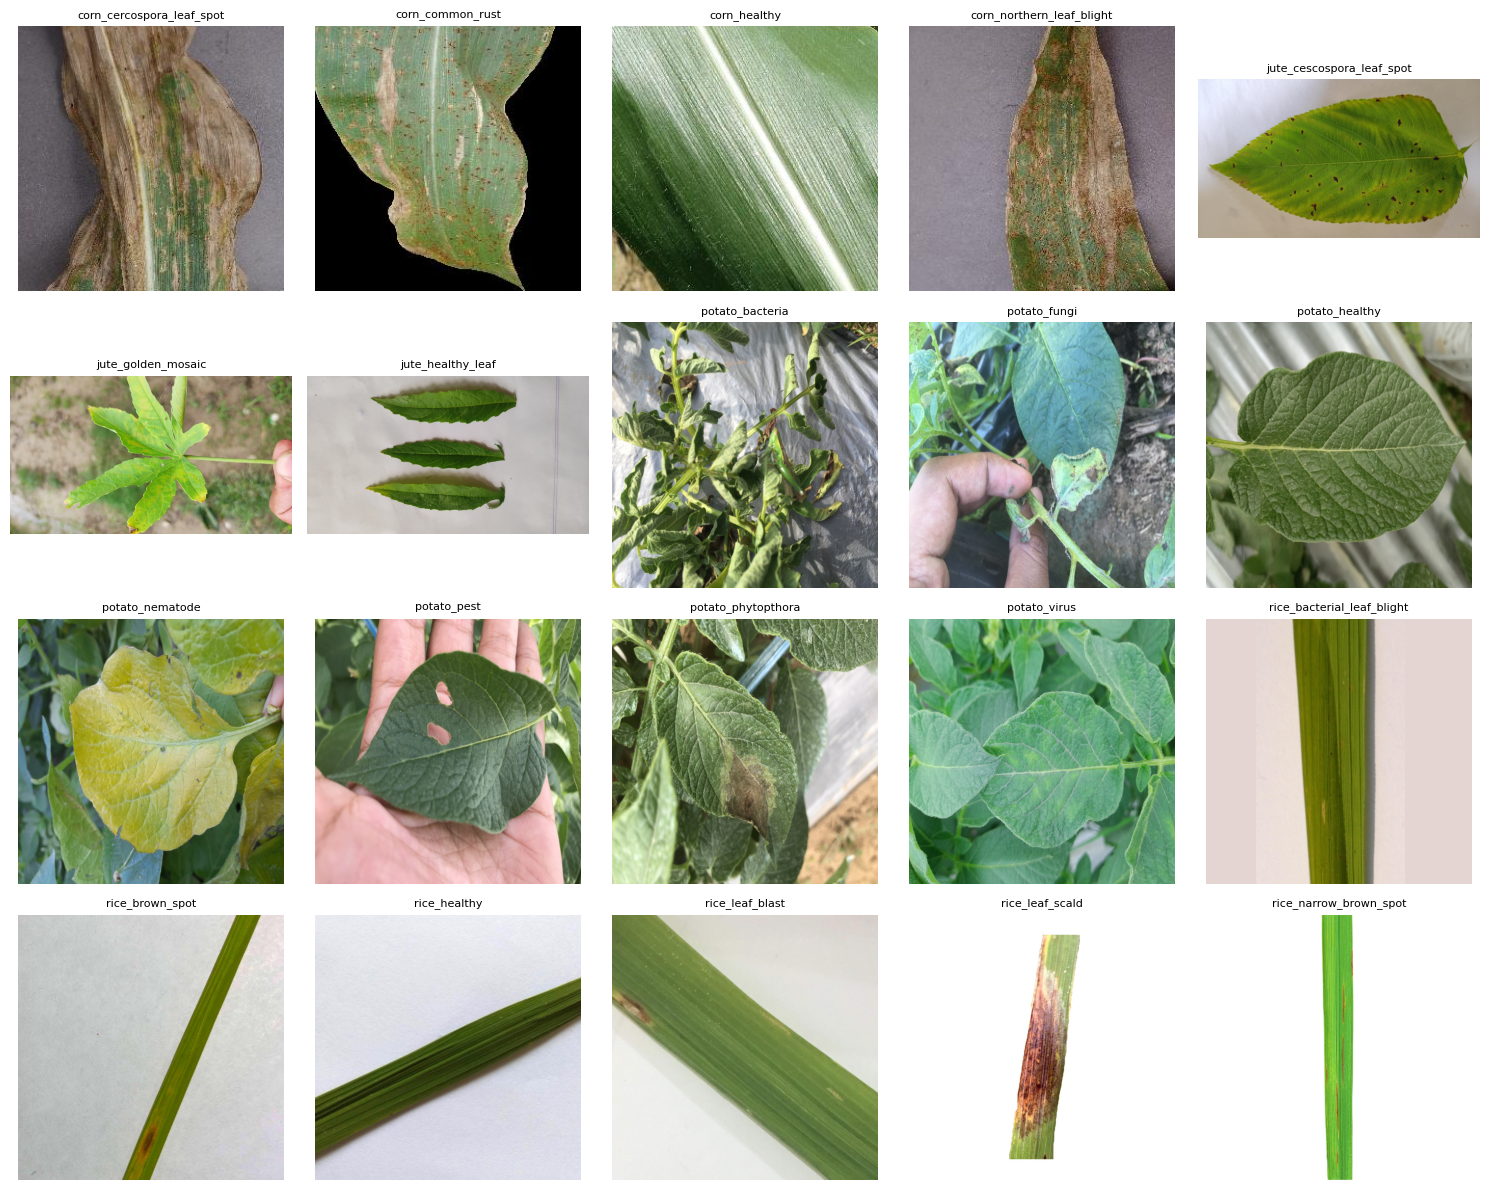


Dataset Statistics:
Total images: 18592
Average images per class: 619.7
Minimum images per class: 68
Maximum images per class: 1658

Sanity Check:
✅ Image count matches expected total.


In [14]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

def explore_dataset_2level(data_path, num_samples=20):
    if not os.path.exists(data_path):
        print(f"Error: Dataset not found at {data_path}")
        print("Please place your dataset in data/raw/agrofusionnet_dataset/")
        return None, None
    
    # Get all crop folders
    crop_folders = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    print(f"Found {len(crop_folders)} crop types: {crop_folders}")
    
    # Count images per class (crop + disease)
    class_counts = []
    all_classes = []
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.gif', '.webp', '.jfif')


    for crop in crop_folders:
        crop_path = os.path.join(data_path, crop)
        disease_folders = [d for d in os.listdir(crop_path) if os.path.isdir(os.path.join(crop_path, d))]
        
        for disease in disease_folders:
            disease_path = os.path.join(crop_path, disease)
            images = [f for f in os.listdir(disease_path) if f.lower().endswith(valid_exts)]
            num_images = len(images)

            if num_images > 0:  # ✅ skip empty folders
                class_name = f"{crop}_{disease}"
                class_counts.append((class_name, num_images))
                all_classes.append(class_name)
                print(f"  {class_name}: {num_images} images")
    
    # Create DataFrame
    df = pd.DataFrame(class_counts, columns=['Class', 'Count'])
    df = df.sort_values('Count', ascending=False)
    
    print(f"\nTotal {len(df)} classes found")
    print("\nTop 10 classes by image count:")
    print(df.head(10))
    
    # Plot class distribution
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(df)), df['Count'])
    plt.title('Number of Images per Class', fontsize=14)
    plt.xlabel('Class Index')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('C:/Users/ZA SEYAM/AgroFusionNet/results/class_distribution_raw.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Debug block: recount across folders and catch non-image files
    folder_total = 0
    for crop in crop_folders:
        crop_path = os.path.join(data_path, crop)
        for disease in os.listdir(crop_path):
            disease_path = os.path.join(crop_path, disease)
            if os.path.isdir(disease_path):
                all_files = os.listdir(disease_path)
                image_files = [f for f in all_files if f.lower().endswith(valid_exts)]
                other_files = [f for f in all_files if not f.lower().endswith(valid_exts)]
                
                if other_files:  # suspicious non-image files
                    print(f"⚠️ Non-image files in {crop}/{disease}: {other_files}")
                
                folder_total += len(image_files)

    print(f"\nRecount total across folders (with more formats): {folder_total}")
    
    # Display sample images
    print(f"\nSample {num_samples} images from dataset:")
    
    rows = (num_samples + 4) // 5   # 5 columns, adjust rows automatically
    cols = 5
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()
    
    sample_count = 0
    for crop in crop_folders:
        crop_path = os.path.join(data_path, crop)
        disease_folders = [d for d in os.listdir(crop_path) if os.path.isdir(os.path.join(crop_path, d))]
        
        for disease in disease_folders:
            if sample_count >= num_samples:
                break
                
            disease_path = os.path.join(crop_path, disease)
            images = [f for f in os.listdir(disease_path) if f.lower().endswith(valid_exts)]
            
            if images:
                img_file = random.choice(images)  # pick random image
                img_path = os.path.join(disease_path, img_file)
                img = Image.open(img_path)
                
                axes[sample_count].imshow(img)
                axes[sample_count].set_title(f"{crop}_{disease}", fontsize=8)
                axes[sample_count].axis('off')
                
                sample_count += 1
    
    # Hide empty subplots
    for i in range(sample_count, rows * cols):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('C:/Users/ZA SEYAM/AgroFusionNet/results/sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Dataset statistics
    print("\nDataset Statistics:")
    total_images = df['Count'].sum()
    avg_images = df['Count'].mean()
    min_images = df['Count'].min()
    max_images = df['Count'].max()
    
    print(f"Total images: {total_images}")
    print(f"Average images per class: {avg_images:.1f}")
    print(f"Minimum images per class: {min_images}")
    print(f"Maximum images per class: {max_images}")
    
    # ✅ Sanity check
    print("\nSanity Check:")
    expected_total = 18592  # update this if dataset grows
    if total_images != expected_total:
        print(f"⚠️ Warning: Counted {total_images} images, but expected {expected_total}. Check for unsupported formats or hidden files.")
    else:
        print("✅ Image count matches expected total.")
    
    return df, all_classes


# Explore the dataset
data_path = "C:/Users/ZA SEYAM/AgroFusionNet/data/raw/agrofusionnet_dataset"
df, all_classes = explore_dataset_2level(data_path, num_samples=20)


## Data Preprocessing

In [4]:
print("\n=== Data Preprocessing ===")

def organize_dataset(raw_data_path, processed_data_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Split dataset into train, validation, and test sets for 2-level structure"""
    if not os.path.exists(raw_data_path):
        print(f"Error: Raw dataset not found at {raw_data_path}")
        return
    
    # If processed path already exists, clear it to avoid duplicates
    if os.path.exists(processed_data_path):
        shutil.rmtree(processed_data_path)
    os.makedirs(processed_data_path, exist_ok=True)
    
    # Get all crop folders
    crop_folders = [d for d in os.listdir(raw_data_path) if os.path.isdir(os.path.join(raw_data_path, d))]
    print(f"Found {len(crop_folders)} crop types: {crop_folders}")
    
    # Create directories for each split
    for split in ['train', 'validation', 'test']:
        os.makedirs(os.path.join(processed_data_path, split), exist_ok=True)
    
    # Process each crop and disease
    for crop in crop_folders:
        crop_path = os.path.join(raw_data_path, crop)
        disease_folders = [d for d in os.listdir(crop_path) if os.path.isdir(os.path.join(crop_path, d))]
        
        for disease in disease_folders:
            disease_path = os.path.join(crop_path, disease)
            class_name = f"{crop}_{disease}"
            
            # Create class directories in each split
            for split in ['train', 'validation', 'test']:
                os.makedirs(os.path.join(processed_data_path, split, class_name), exist_ok=True)
            
            print(f"Processing {class_name}...")
            
            # Get all images
            images = [f for f in os.listdir(disease_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            if not images:
                print(f"  No images found in {class_name}")
                continue
            
            # Split images
            train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
            val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)
            
            print(f"  {len(train_imgs)} train, {len(val_imgs)} validation, {len(test_imgs)} test")
            
            # Function to copy only valid images
            def copy_images(img_list, split_name):
                for img in img_list:
                    src = os.path.join(disease_path, img)
                    dst = os.path.join(processed_data_path, split_name, class_name, img)
                    try:
                        with Image.open(src) as im:
                            im.verify()  # check if image is valid
                        shutil.copy2(src, dst)
                    except Exception as e:
                        print(f"⚠️ Skipping corrupted image: {src} ({e})")
            
            # Copy valid images to respective directories
            copy_images(train_imgs, 'train')
            copy_images(val_imgs, 'validation')
            copy_images(test_imgs, 'test')
    
    print("✅ Dataset organization completed!")
    
    # Verify the processed dataset
    train_path = os.path.join(processed_data_path, "train")
    val_path = os.path.join(processed_data_path, "validation")
    test_path = os.path.join(processed_data_path, "test")
    
    print(f"\nTrain set: {sum([len(files) for r, d, files in os.walk(train_path)])} images")
    print(f"Validation set: {sum([len(files) for r, d, files in os.walk(val_path)])} images")
    print(f"Test set: {sum([len(files) for r, d, files in os.walk(test_path)])} images")

# Define transforms (same as before)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined successfully!")

# Run preprocessing if dataset exists
raw_path = "C:/Users/ZA SEYAM/AgroFusionNet/data/raw/agrofusionnet_dataset"
processed_path = "C:/Users/ZA SEYAM/AgroFusionNet/data/processed"

if os.path.exists(raw_path):
    organize_dataset(raw_path, processed_path)
else:
    print(f"Raw dataset not found at {raw_path}. Please add your dataset and run this cell again.")



=== Data Preprocessing ===
Transforms defined successfully!
Found 6 crop types: ['corn', 'jute', 'potato', 'rice', 'sugarcane', 'wheat']
Processing corn_cercospora_leaf_spot...
  359 train, 77 validation, 77 test
Processing corn_common_rust...
  834 train, 179 validation, 179 test
Processing corn_healthy...
  811 train, 174 validation, 175 test
Processing corn_northern_leaf_blight...
  689 train, 148 validation, 148 test
Processing jute_cescospora_leaf_spot...
  216 train, 46 validation, 47 test
Processing jute_golden_mosaic...
  242 train, 52 validation, 53 test
Processing jute_healthy_leaf...
  184 train, 40 validation, 40 test
Processing potato_bacteria...
  398 train, 85 validation, 86 test
Processing potato_fungi...
  523 train, 112 validation, 113 test
Processing potato_healthy...
  140 train, 30 validation, 31 test
Processing potato_nematode...
  47 train, 10 validation, 11 test
Processing potato_pest...
  427 train, 92 validation, 92 test
Processing potato_phytopthora...
  242

## Plot the dataset

In [5]:
def plot_split_distribution(processed_data_path, save_dir="results"):
    os.makedirs(save_dir, exist_ok=True)  # make sure results folder exists
    
    data = []
    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(processed_data_path, split)
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
                data.append([class_name, split, count])
    
    df = pd.DataFrame(data, columns=['Class','Split','Count'])
    
    # Pivot for grouped bar chart
    pivot_df = df.pivot(index='Class', columns='Split', values='Count').fillna(0)
    
    # Split into two halves for readability
    classes = pivot_df.index.tolist()
    mid = len(classes) // 2
    halves = [pivot_df.iloc[:mid], pivot_df.iloc[mid:]]
    
    fig, axes = plt.subplots(2, 1, figsize=(16,12), sharey=True)
    
    for i, half in enumerate(halves):
        ax = half.plot(kind='bar', ax=axes[i])
        ax.set_ylabel("Number of Images")
        ax.set_title(f"Dataset Split Distribution (Part {i+1})")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        
        # Add counts on top of bars
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(str(int(height)), 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom', fontsize=7, rotation=90)
    
    plt.tight_layout()
    
    # Save figure
    save_path = os.path.join(save_dir, "dataset_split_distribution.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Split distribution saved at: {save_path}")
    return pivot_df

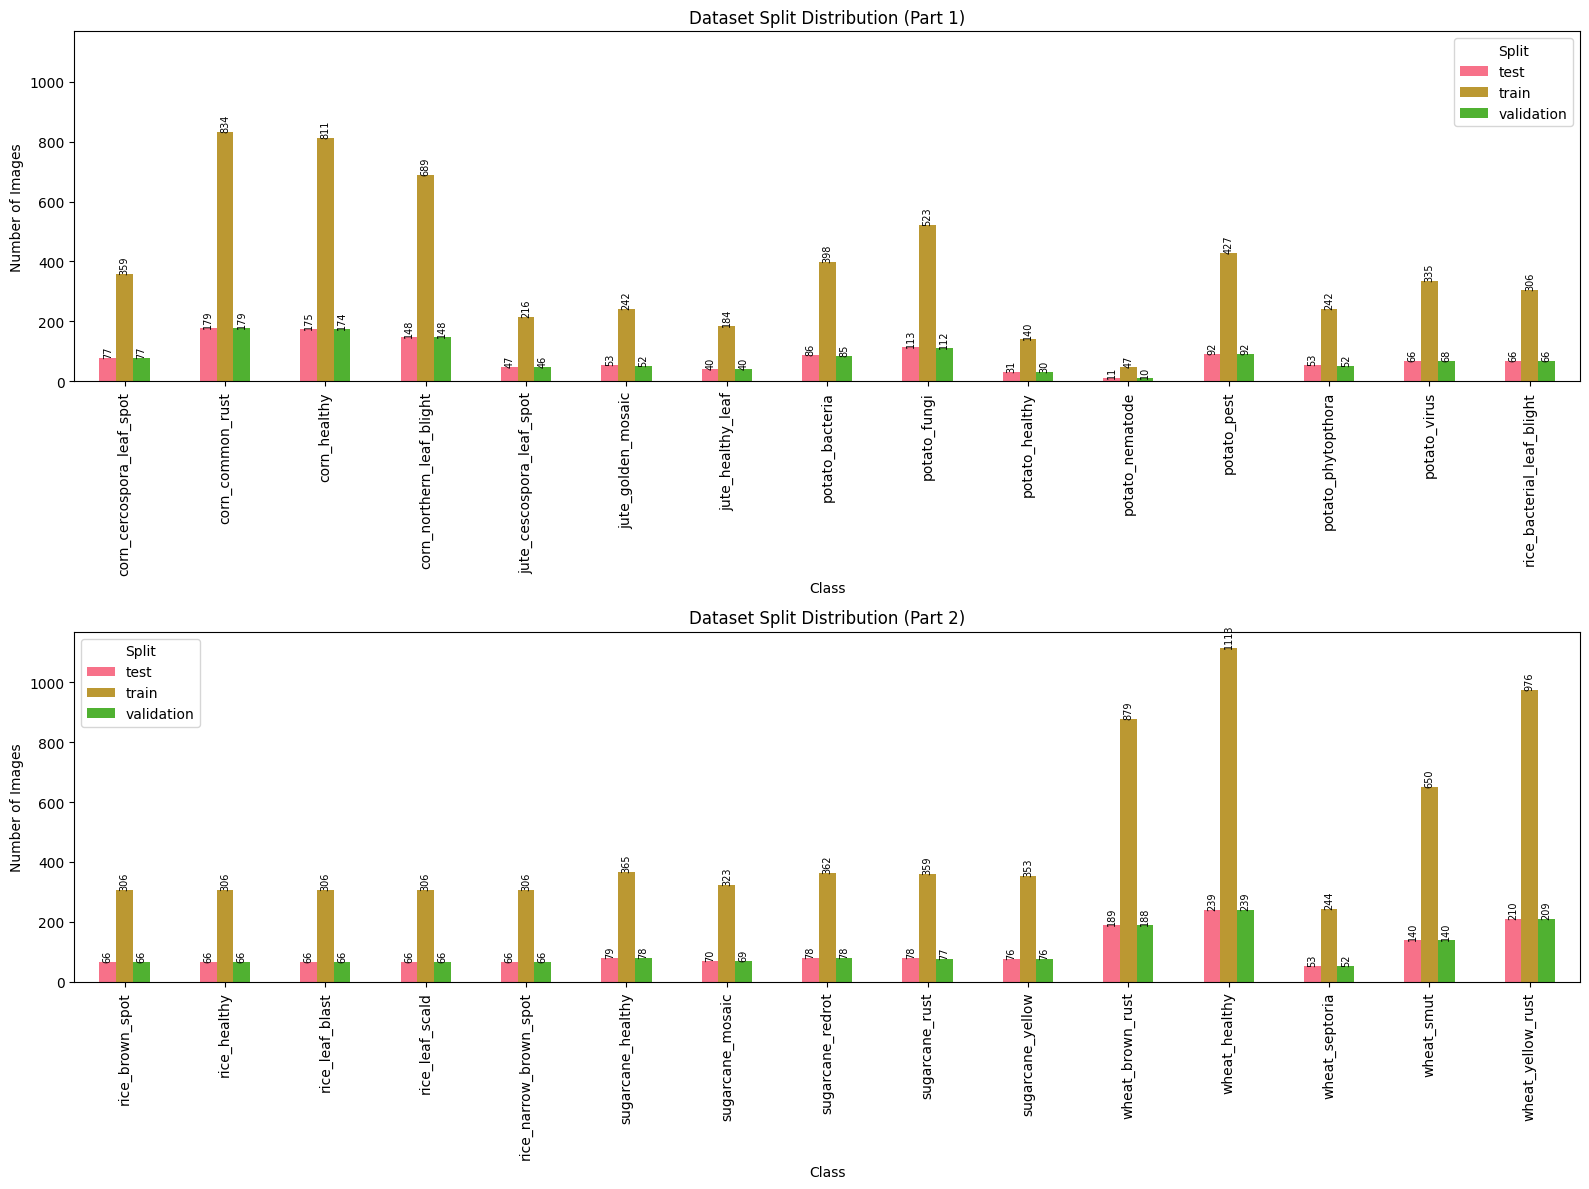

✅ Split distribution saved at: results\dataset_split_distribution.png


Split,test,train,validation
Class,,,
corn_cercospora_leaf_spot,77,359,77
corn_common_rust,179,834,179
corn_healthy,175,811,174
corn_northern_leaf_blight,148,689,148
jute_cescospora_leaf_spot,47,216,46
jute_golden_mosaic,53,242,52
jute_healthy_leaf,40,184,40
potato_bacteria,86,398,85
potato_fungi,113,523,112


In [6]:
processed_path = "C:/Users/ZA SEYAM/AgroFusionNet/data/processed"
plot_split_distribution(processed_path)